# Credit Card Default Prediction

The purpose of this notebook it to construct a full machine learning pipeline to predict the probability of a customer defaulting on their credit card debt. The assignment prompt for this is adapted from an assignment in UBC MDS DSCI 573, but has been reworked. The data is sourced from the Kaggle Credit Card Clients Dataset, found here https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset

# TO DO

Fix double ordinal encoding in preprocessor

# The Problem

The problem is a classification task to identify customers who will default on their credit card payments in the next month. In the raw data set, this column is labeled as `default.payment.next.month`, but this will be re-labeled and referred to to as `default` for convenience. A 0 indicates no default, and a 1 indicates a default. There is significant class imbalance in the dataset, with the majority being non default. As such the analysis will be primarily concerned with metrics related to the identifying the positive class (default), and this can be considered an anomaly detection problem, meaning raw accuracy is an unreliable metric. 

Initial model evaluation will be based on maximal f1 score. This analysis will consider a balanced approach, as we want to avoid casting an overly broad net and having excessive false positives to ensure that intervention as specifically targeted as possible. However, we can consider minimizing false negatives (recall) to be more damaging due to profit loss to the credit card company, while intervention against an individual who would not default may be still warranted if the model identifies them as sufficiently high risk. Overall, we want a somewhat balanced model that still prioritizes minimizing type II error (false negative) over type I error (false postive).

The ideal method would be to set an minimum acceptable operating point for precision, and use this to determine a probability threshold that maximizes recall for each model. The model with the highest recall at this operating point is the model selected by this modeling process. However, setting this operating point requires additional industry knowledge, as well as being specific to the risk tolerance of the company/ deployment context.

# Imports, Download, Reformatting, Splitting

In [1]:
import altair as alt
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.linear_model import LogisticRegression



In [2]:
cc_df = pd.read_csv('data/UCI_Credit_Card.csv').rename(columns = {"default.payment.next.month":"default"})

# Some rows seem to be missing all bill values -- possibly not active customers or error. Drop these
cc_df = cc_df[cc_df.loc[:,'BILL_AMT1':'BILL_AMT6'].sum(axis=1)!=0]

cc_df.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


In [3]:
train_df, test_df = train_test_split(cc_df, test_size=0.20, random_state=123)
train_df.shape

(23304, 25)

In [4]:
test_df.shape

(5826, 25)

# EDA

#### Observations

1. Approximately 22% of examples are default (positive class), 78% are not.
2. We have 24 potential features and one target

Feature Descriptions:

* `ID`: Unique identifier, will be dropped
* `LIMIT_BAL`: Maximum credit, numeric
* `SEX` : Binary/ Numeric. We don't necessarily want to make decisions on default prediction based on sex for ethical reasons, so this will be dropped.
* `EDUCATION`: Ordinal Feature for education level. According to the dataset description, 5 and 6 are unknown. These will be combined into a single category and changed to a value of zero. 
* `MARRIAGE`: Married, Unmarried, Others. This is not ordinal as we don't know relative order, so it will be one hot encoded as a categorical. There are also some unused unlabeled values (54 cases of 0, possibly meaning missing data), which will be combined into others

* `AGE`: a numeric integer
* `PAY_0` -> `PAY_6`: Series of ordinals indicating payment behavior, with 0 being the most recent month at the time of data collection, and each following feature being a month prior. Low values are good payment behaviors (i.e. -1 is paid duly), while positive values indicate how delayed payment is (i.e. 2 is 2 months delayed). There are unlabeled values (0 and -2), I speculate that a 0 is something like partial repayment, and a -2 is overpayment or no credit used. Regardless, these are relative uncommon and will be kept to maintain ordinality. There is obvious correlation between sequential columns, as if an individual is 6 months late in `PAY_0`, we know they must have been 5 months late in `PAY_1`. Conversely, in a predictive sense, if we know `PAY_1` is a large positive number, then that individual is clearly not paying their bill and `PAY_0` is more likely to be the next integer, rather than the individual suddenly paying their bill.
* `BILL_AMT1` -> `BILL_AMT6`: follows same time series as the `PAY` columns. Numeric indicating amount owing
* `PAY_AMT1` -> `PAY_AMT6`: follows same time series as the `PAY` columns. Numeric indicating payment made.


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23304 entries, 23114 to 20565
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         23304 non-null  int64  
 1   LIMIT_BAL  23304 non-null  float64
 2   SEX        23304 non-null  int64  
 3   EDUCATION  23304 non-null  int64  
 4   MARRIAGE   23304 non-null  int64  
 5   AGE        23304 non-null  int64  
 6   PAY_0      23304 non-null  int64  
 7   PAY_2      23304 non-null  int64  
 8   PAY_3      23304 non-null  int64  
 9   PAY_4      23304 non-null  int64  
 10  PAY_5      23304 non-null  int64  
 11  PAY_6      23304 non-null  int64  
 12  BILL_AMT1  23304 non-null  float64
 13  BILL_AMT2  23304 non-null  float64
 14  BILL_AMT3  23304 non-null  float64
 15  BILL_AMT4  23304 non-null  float64
 16  BILL_AMT5  23304 non-null  float64
 17  BILL_AMT6  23304 non-null  float64
 18  PAY_AMT1   23304 non-null  float64
 19  PAY_AMT2   23304 non-null  float64
 20  PA

In [6]:
train_df.nunique()

ID           23304
LIMIT_BAL       80
SEX              2
EDUCATION        7
MARRIAGE         4
AGE             56
PAY_0           11
PAY_2           11
PAY_3           11
PAY_4           11
PAY_5           10
PAY_6           10
BILL_AMT1    18706
BILL_AMT2    18421
BILL_AMT3    18124
BILL_AMT4    17776
BILL_AMT5    17333
BILL_AMT6    17028
PAY_AMT1      6885
PAY_AMT2      6843
PAY_AMT3      6505
PAY_AMT4      6025
PAY_AMT5      5966
PAY_AMT6      5987
default          2
dtype: int64

In [7]:
prop_neg = round(train_df['default'].value_counts()[0]/train_df.shape[0],2)
prop_pos = round(train_df['default'].value_counts()[1]/train_df.shape[0],2)

print (f"Proportion of positive class: {prop_pos}")
print (f"Proportion of negative class: {prop_neg}")

Proportion of positive class: 0.22
Proportion of negative class: 0.78


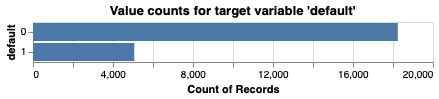

In [8]:
alt.Chart(train_df,title = "Value counts for target variable 'default'").mark_bar().encode(
    y = alt.Y("default:N"),
    x = alt.X("count()"))

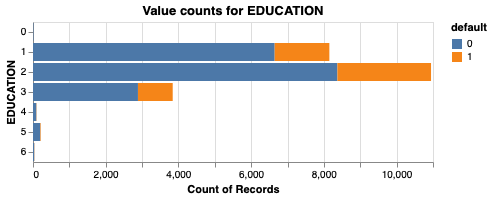

In [9]:
alt.Chart(train_df,title = "Value counts for EDUCATION").mark_bar().encode(
    y = alt.Y("EDUCATION:N"),
    x = alt.X("count()"),
color = alt.Color('default:N'))

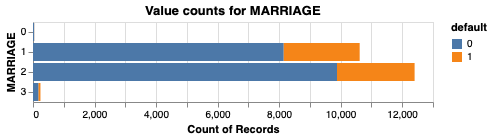

In [10]:
alt.Chart(train_df,title = "Value counts for MARRIAGE").mark_bar().encode(
    y = alt.Y("MARRIAGE:N"),
    x = alt.X("count()"),
color = alt.Color('default:N'))

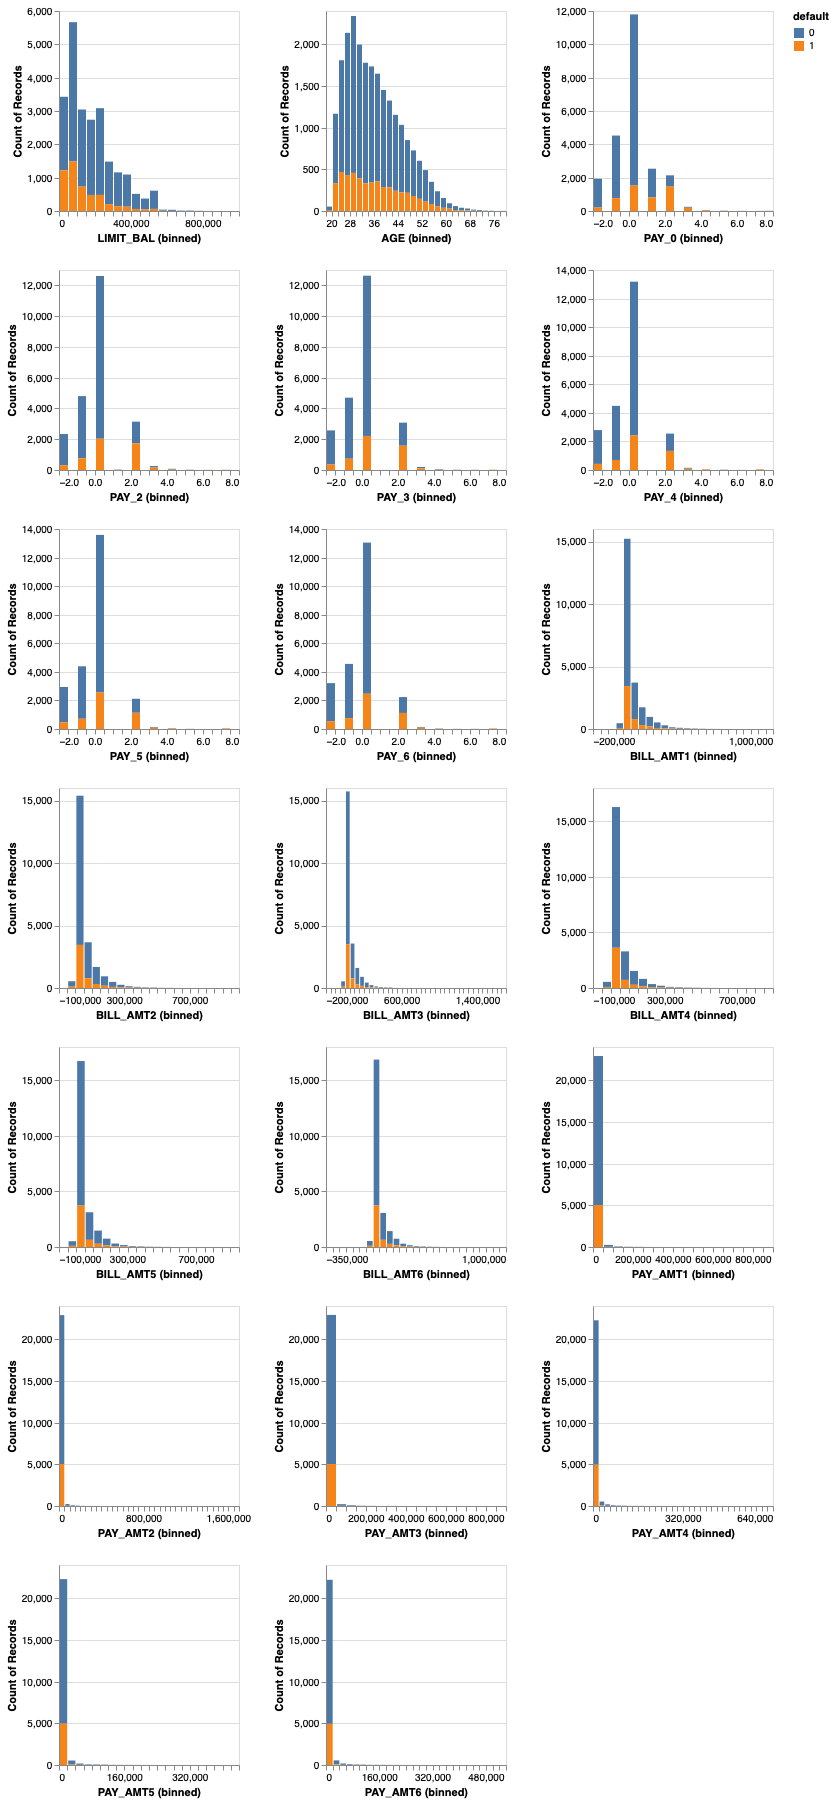

In [11]:
numeric_cols = train_df.select_dtypes(
    include=np.number).drop(
    columns=["ID", "SEX", "default", "MARRIAGE", "EDUCATION"]).columns.to_list()

alt.Chart(train_df).mark_bar().encode(
    alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=40)),
    y='count()',
    color='default:N'
).properties(
    width=180,
    height=200
).repeat(
    numeric_cols, columns=3
)

In [12]:
train_df[numeric_cols].corr('kendall').style.background_gradient()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
LIMIT_BAL,1.000000,0.131779,-0.237038,-0.268373,-0.258503,-0.240751,-0.219675,-0.205549,0.092536,0.087368,0.092922,0.096039,0.098858,0.102886,0.228964,0.231723,0.236109,0.233656,0.241166,0.256385
AGE,0.131779,1.000000,-0.050595,-0.060349,-0.060294,-0.058086,-0.059998,-0.056172,0.011452,0.012238,0.012562,0.008041,0.009296,0.008717,0.033434,0.041956,0.032843,0.036711,0.034340,0.035305
PAY_0,-0.237038,-0.050595,1.000000,0.651403,0.547391,0.515548,0.485602,0.456179,0.266036,0.268999,0.258192,0.251179,0.243244,0.235635,-0.077176,-0.045156,-0.041377,-0.026940,-0.020122,-0.034307
PAY_2,-0.268373,-0.060349,0.651403,1.000000,0.744246,0.643324,0.600948,0.556894,0.401564,0.388627,0.362467,0.345491,0.330518,0.317540,-0.044585,0.008570,0.010722,0.019331,0.023161,0.014554
PAY_3,-0.258503,-0.060294,0.547391,0.744246,1.000000,0.746045,0.647590,0.595340,0.361118,0.418469,0.397471,0.375386,0.356580,0.340381,0.121662,-0.032065,0.022285,0.040792,0.044929,0.029804
PAY_4,-0.240751,-0.058086,0.515548,0.643324,0.746045,1.000000,0.771896,0.662369,0.352158,0.393205,0.450043,0.432896,0.404379,0.383764,0.093141,0.148982,-0.009804,0.059728,0.076699,0.067910
PAY_5,-0.219675,-0.059998,0.485602,0.600948,0.647590,0.771896,1.000000,0.770312,0.346392,0.381283,0.426259,0.485475,0.462619,0.428011,0.085656,0.128916,0.160215,0.029647,0.097097,0.093750
PAY_6,-0.205549,-0.056172,0.456179,0.556894,0.595340,0.662369,0.770312,1.000000,0.334737,0.366422,0.400358,0.443267,0.501123,0.471536,0.085051,0.105313,0.139497,0.181310,0.054586,0.110936
BILL_AMT1,0.092536,0.011452,0.266036,0.401564,0.361118,0.352158,0.346392,0.334737,1.000000,0.806192,0.725998,0.656554,0.609968,0.571007,0.367968,0.337232,0.304537,0.305664,0.290182,0.282848
BILL_AMT2,0.087368,0.012238,0.268999,0.388627,0.418469,0.393205,0.381283,0.366422,0.806192,1.000000,0.799521,0.712527,0.652694,0.608829,0.486725,0.364077,0.331197,0.324764,0.313073,0.302004


In [13]:
# recategorizing classses 0, 5, 6 in education as "Others" for train
train_df['EDUCATION'] = train_df['EDUCATION'].replace([0, 5, 6], 4)

# recategorizing class 0 in marriage as "Others" for train
train_df['MARRIAGE'] = train_df['MARRIAGE'].replace(0, 3)

# recategorizing classses 0, 5, 6 in education as "Others" for test
test_df['EDUCATION'] = test_df['EDUCATION'].replace([0, 5, 6], 4)

# recategorizing class 0 in marriage as "Others" for test                
test_df['MARRIAGE'] = test_df['MARRIAGE'].replace(0, 3)

# Feature Engineering

1. **Max of `PAY` series**: The `PAY` series of features provides a qualitative description of the pay behavior of a customer in a given month. As previously discussed, when a customer repeatedly does not pay their balance across multiple months, this series of features becomes sequential. We can create a feature that describes a customer's overall worst case payment behavior (longest time without a payment) in a single feature by taking the max of these features.

2. **Sum of `BILL_AMT` series**: The `BILL` series describes the amount of money owed by the customer. Instead of dividing this over multiple features, it may be useful to condense it into a single feature correlated to the total amount of money owed. Note that this value is not necessarily the sum of charges on the card, as an unpaid charge of \$2000 in `BILL_AMT_6` would be carried forward into `BILL_AMT_5`, giving this feature a value of \$4000 without any additional spending occurring. 

3. **Sum of `PAY_AMT` series**: The `PAY_AMT` series describes the amount of money paid by the customer. Similar to the above, it may be helpful to summarize this value into a single feature. Note that this value should actually be equal to the total amount paid by the customer, as the values each month are not carried forward as in the case of unpaid bills.

4. **Payment Ratio**: This feature will describe the mean proportion of their bill that a customer pays off. For example, for a single month we would compute `PAY_AMT1` / `BILL_AMT2` (adjusted for payment time lag). This would be equal to 1 for a full repayment, 0 for no payment, and somewhere between 0 and 1 for a partial repayment. This calculation is repeated for all Pay/Bill pairs and averaged to find the mean ratio. Note that to prevent division by zero, if the `BILL_AMT` is equal to 0, we will set the pay ratio to 1.

In [14]:
# creating total_pay for train
train_df = train_df.assign(longest_unpaid_streak=train_df.loc[:, "PAY_0":"PAY_6"].max(axis=1))

# creating total_bill for train
train_df = train_df.assign(total_bill=train_df.loc[:, "BILL_AMT1":"BILL_AMT6"].sum(axis=1))

# creating total_paid for train
train_df = train_df.assign(total_paid=train_df.loc[:, "PAY_AMT1":"PAY_AMT6"].sum(axis=1))

# creating avg_pay_ratio for train (assumption: if bill_amt = 0, pay_ratio = 1)
np_pay_amt = np.array(train_df.loc[:, "PAY_AMT1":"PAY_AMT5"])
np_bill_amt = np.array(train_df.loc[:, "BILL_AMT2":"BILL_AMT6"])
train_df['avg_pay_ratio'] = np.average(np.divide(np_pay_amt, np_bill_amt, out=np.ones_like(np_pay_amt), where=np_bill_amt!=0), axis=1)

# creating total_pay for test
test_df = test_df.assign(longest_unpaid_streak=test_df.loc[:, "PAY_0":"PAY_6"].max(axis=1))

# creating total_bill for test
test_df = test_df.assign(total_bill=test_df.loc[:, "BILL_AMT1":"BILL_AMT6"].sum(axis=1))

# creating total_paid for test
test_df = test_df.assign(total_paid=test_df.loc[:, "PAY_AMT1":"PAY_AMT6"].sum(axis=1))

# creating avg_pay_ratio for test (assumption: if bill_amt = 0, pay_ratio = 1)
np_pay_amt = np.array(test_df.loc[:, "PAY_AMT1":"PAY_AMT5"])
np_bill_amt = np.array(test_df.loc[:, "BILL_AMT2":"BILL_AMT6"])
test_df['avg_pay_ratio'] = np.average(np.divide(np_pay_amt, np_bill_amt, out=np.ones_like(np_pay_amt), where=np_bill_amt!=0), axis=1)

# Preprocessing, X/y split

* We will drop `ID` (unique identifier) and `Sex` (ethical concerns, don't want to deny credit based on sex)
* `MARRIAGE` will be considered a categorical -- not sure if the ordering is sequential
* `EDUCATION` will be considered an ordinal -- values ordered from less to more education.
* `PAY` variables will be encoded as ordinal; values are sequential with negative or zero indicating good payment habits/ no credit use, and positive values indicating degree of lateness. 
* All other features are numeric



In [18]:
# Creating X_train, y_train, X_test and y_test
X_train = train_df.drop(columns='default')
y_train = train_df['default']
X_test = test_df.drop(columns='default')
y_test = test_df['default']


# Creating the preprocessor
# drop_features = ['ID', 'SEX']
# numeric_features = ['LIMIT_BAL', 'AGE',
#                     'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
#                     'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
#                     'longest_unpaid_streak', 'total_bill', 'total_paid', 'avg_pay_ratio']
# ordinal_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
# categorical_features = ['MARRIAGE']

# education_levels = [1, 2, 3, 4]
# ordinal_levels = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

# preprocessor = make_column_transformer(
#     (StandardScaler(), numeric_features),
#     (OrdinalEncoder(categories=[ordinal_levels]), ordinal_features),
#     (OrdinalEncoder(categories=[education_levels]), 'EDUCATION'),
#     (OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features),
#     ("drop", drop_features))

drop_features = ['ID', 'SEX']
numeric_features = ['LIMIT_BAL', 'AGE',
                    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                    'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                    'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                    'longest_unpaid_streak', 'total_bill', 'total_paid', 'avg_pay_ratio']
ordinal_features = ['EDUCATION']
categorical_features = ['MARRIAGE']

ordinal_levels = [1, 2, 3, 4]

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OrdinalEncoder(categories=[ordinal_levels]), ordinal_features),
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features),
    ("drop", drop_features))

# Models

## Baseline Dummy Model

Set up a dummy model as a baseline. Because the Dummy will always predict no default, we see 0 in all scoring metrics besides accuracy (no True Positives or False Positives)

In [16]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

classification_metrics = ["accuracy", "precision", "recall", "f1"]
dc = DummyClassifier()
cross_val_results = {}
cross_val_results['dummy'] = (pd.DataFrame(cross_validate(dc,
                                                         X_train,
                                                         y_train,
                                                         return_train_score=True,
                                                         scoring=classification_metrics))
                              .agg(['mean', 'std']).round(3).T)

# Show the train and validation scores
cross_val_results['dummy']

,mean,std
fit_time,0.002,0.0
score_time,0.003,0.0
test_accuracy,0.783,0.0
train_accuracy,0.783,0.0
test_precision,0.000,0.0
train_precision,0.000,0.0
test_recall,0.000,0.0
train_recall,0.000,0.0
test_f1,0.000,0.0
train_f1,0.000,0.0


## Logistic Regression

CV f1 score is 0.519. 

CV f1 score is very close to train f1 score (0.521) so we are likely not overfitting.

Balanced class weight has been selected, shifting us towards higher recall and lower precision

In [20]:
from scipy.stats import lognorm, loguniform, randint

pipe_logreg = make_pipeline(preprocessor, LogisticRegression(random_state=123,
                                                        max_iter=1000))

param_dist_logreg = {
    "logisticregression__class_weight": [None, 'balanced'],
    "logisticregression__C": loguniform(1e-3, 1e3)
}

random_search_logreg = RandomizedSearchCV(
    pipe_logreg,
    param_distributions=param_dist_logreg,
    n_iter=20,
    random_state=123,
    return_train_score=True,
    scoring = 'f1')
random_search_logreg.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_AMT6',
                                                                                'longest_unp...
                                                                               ['MARRIAGE']),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['ID',
                                                                                'SEX'])])),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=1000,
                                                                 random_state=123))]),
                   n_iter=20,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x13f279210>,
                                        'logisticregression__class_weight': [None,
                                                                             'balanced']},
                   random_state=123, return_train_score=True, scoring='f1')

In [21]:
random_search_logreg.best_params_

{'logisticregression__C': 2.0318358298265977,
 'logisticregression__class_weight': 'balanced'}

In [22]:
cross_val_results['logreg'] = pd.DataFrame(cross_validate(random_search_logreg.best_estimator_,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['logreg']

,mean,std
fit_time,0.050,0.004
score_time,0.006,0.000
test_accuracy,0.737,0.005
train_accuracy,0.739,0.002
test_precision,0.431,0.006
train_precision,0.433,0.003
test_recall,0.654,0.015
train_recall,0.653,0.002
test_f1,0.519,0.004
train_f1,0.521,0.003
